**Кейс №2 - Приложение доставки**

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

В данных вы найдете логи заказов пользователей:

**ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

**ab_orders** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

**ab_products** – подробная информация о продуктах, их название и стоимость

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import scipy

In [2]:
df_ab_orders = pd.read_csv('ab_orders.csv')
df_ab_products = pd.read_csv('ab_products.csv')
df_ab_users_data = pd.read_csv('ab_users_data.csv')

In [3]:
df_ab_orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [4]:
df_ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [5]:
df_ab_products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [6]:
df_ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [7]:
df_ab_users_data

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [8]:
df_ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


После просмотра датафреймов приведу колонки, в которых подразумевается тип данных datetime к типу datetime.

In [9]:
df_ab_users_data['time'] = pd.to_datetime(df_ab_users_data.time)

In [10]:
df_ab_orders['creation_time'] = pd.to_datetime(df_ab_orders.creation_time)

Продукты, которые фигурируют в заказе, здесь представлены в формате множества, но так как изначально эта колонка считывается строковым типом данных, можно удалить фигурные скобки, по запятой разделить айди товаров и сделать из этого список и список уже разбить (методом pd.explode) так, чтобы для каждого продукта внутри одного заказа была своя строчка. Также надо привести разложенную колонку с айди продуктов к типу int, чтобы можно было джойнить по этому ключу (в другой таблице df_ab_products колонка product_id также с типом int).

In [11]:
df_ab_orders['product_ids'] = df_ab_orders.product_ids.apply(lambda x: x.replace('{', '').replace('}', '').split(','))
df_ab_orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"[74, 6]"
4,1259,2022-08-26 00:03:37,"[20, 45, 67, 26]"
...,...,...,...
4118,59422,2022-09-08 23:13:03,"[84, 8, 24]"
4119,59439,2022-09-08 23:18:05,"[9, 25, 75, 30, 6]"
4120,59464,2022-09-08 23:22:27,"[60, 41, 46]"
4121,59487,2022-09-08 23:29:06,"[9, 62, 77]"


In [12]:
df_ab_orders = df_ab_orders.explode('product_ids').rename(columns={'product_ids': 'product_id'})
df_ab_orders['product_id'] = df_ab_orders.product_id.astype('int')
df_ab_orders

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19,75
0,1255,2022-08-26 00:00:19,22
0,1255,2022-08-26 00:00:19,53
0,1255,2022-08-26 00:00:19,84
1,1256,2022-08-26 00:02:21,56
...,...,...,...
4121,59487,2022-09-08 23:29:06,9
4121,59487,2022-09-08 23:29:06,62
4121,59487,2022-09-08 23:29:06,77
4122,59533,2022-09-08 23:41:24,17


In [13]:
df_ab = df_ab_orders.merge(df_ab_products, on='product_id')
df_ab

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0
1,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0
2,1403,2022-08-26 03:01:40,75,сок ананасовый,120.0
3,1424,2022-08-26 04:01:22,75,сок ананасовый,120.0
4,1495,2022-08-26 06:04:05,75,сок ананасовый,120.0
...,...,...,...,...,...
13821,33910,2022-09-03 23:46:53,11,масло льняное,200.0
13822,34742,2022-09-04 03:41:52,11,масло льняное,200.0
13823,41998,2022-09-05 10:26:46,11,масло льняное,200.0
13824,53851,2022-09-07 23:53:54,11,масло льняное,200.0


In [14]:
df_ab = df_ab.merge(df_ab_users_data, on='order_id')
df_ab

,order_id,creation_time,product_id,name,price,user_id,action,time,date,group
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
1,1255,2022-08-26 00:00:19,22,сок мультифрукт,120.0,964,create_order,2022-08-26 00:00:19,2022-08-26,0
2,1255,2022-08-26 00:00:19,53,мука,78.3,964,create_order,2022-08-26 00:00:19,2022-08-26,0
3,1255,2022-08-26 00:00:19,84,мандарины,90.4,964,create_order,2022-08-26 00:00:19,2022-08-26,0
4,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0,987,create_order,2022-08-26 00:31:36,2022-08-26,0
...,...,...,...,...,...,...,...,...,...,...
14564,25283,2022-09-02 15:27:56,82,лаваш,30.4,1247,create_order,2022-09-02 15:27:56,2022-09-02,1
14565,41639,2022-09-05 08:54:56,82,лаваш,30.4,1657,create_order,2022-09-05 08:54:56,2022-09-05,1
14566,57283,2022-09-08 16:06:17,82,лаваш,30.4,1829,create_order,2022-09-08 16:06:17,2022-09-08,1
14567,57283,2022-09-08 16:06:17,11,масло льняное,200.0,1829,create_order,2022-09-08 16:06:17,2022-09-08,1


После сбора итоговой таблицы необходимо понять по каким метрикам оценивать АБ-тест. Я выделяю 2 основные метрики для оценки качества продукта (приложения доставки в данном случае) - это количество заказов и средний чек. Для начала сравню изменился ли средний чек в новой версии приложения. Буду учитывать во всех сравнениях только неотмененные заказы. Для этого оставляю только те заказы, у которых есть только одно уникальное действие (так как создание заказа происходит первее, логично будет предположить, что если уникальное действие одно, то это только создание заказа).

In [15]:
df_revenue = df_ab.groupby(['order_id', 'group'], as_index=False) \
                .agg({'price': 'sum', 'action': pd.Series.nunique})
df_revenue

,order_id,group,price,action
0,1255,0,408.7,1
1,1256,1,250.5,1
2,1257,0,310.2,1
3,1258,0,170.0,2
4,1259,1,228.0,1
...,...,...,...,...
4118,59422,1,241.2,1
4119,59439,1,518.5,1
4120,59464,0,185.9,1
4121,59487,0,501.9,1


Первая метрика для сравнения - средний чек.

In [16]:
df_revenue_group0 = df_revenue.query("group == 0 & action == 1")
df_revenue_group1 = df_revenue.query("group == 1 & action == 1")

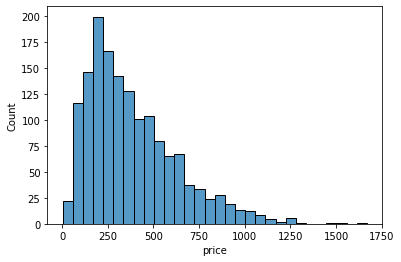

In [17]:
sns.histplot(df_revenue_group0.price)

In [18]:
df_revenue_group0.price.median()

325.9

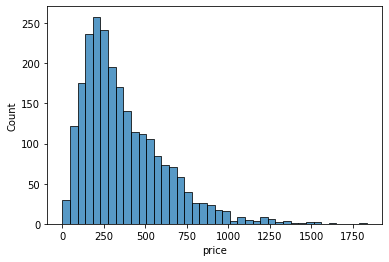

In [19]:
sns.histplot(df_revenue_group1.price)

In [20]:
df_revenue_group1.price.median()

307.35

Распределения потраченных пользователями денег скошенно и не похоже на нормальное, поэтому сравнивать буду медианы. Но тем не менее проведу тесты на нормальность, для того, чтобы убедиться, что распределения от нормального отличаются.

In [21]:
scipy.stats.normaltest(df_revenue_group0.price)

NormaltestResult(statistic=276.0397772146938, pvalue=1.1447851440676955e-60)

In [22]:
scipy.stats.normaltest(df_revenue_group1.price)

NormaltestResult(statistic=586.947837865446, pvalue=3.5147660678462184e-128)

В качестве статистического теста применяю бутстрап по медианам

In [23]:
scipy.stats.bootstrap((df_revenue_group0.price, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=312.19999999999993, high=341.4), standard_error=6.887024283057271)

In [24]:
scipy.stats.bootstrap((df_revenue_group1.price, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=295.95000000000005, high=319.70000000000005), standard_error=6.04439135473634)

Видно, что средний чек уменьшился, но результаты бутстрапа показывают, что доверительные интервалы медиан пересекаются, что не дает отклонить нулевую гипотезу о том, что средний не изменился. Для точности проверю себя тестом Манна-Уитни.

In [25]:
scipy.stats.mannwhitneyu(df_revenue_group0.price, df_revenue_group1.price)

MannwhitneyuResult(statistic=1879866.0, pvalue=0.07540906614048998)

Тест Манна-Уитни также не показывает статзначимых различий в среднем чеке.

Теперь проверяю изменилось ли количество заказов на человека.

In [26]:
df_orders_count = df_ab.query("action == 'create_order'") \
                    .groupby(['user_id', 'group'], as_index=False) \
                    .agg({'order_id': 'count', 'action': pd.Series.nunique})
df_orders_count

,user_id,group,order_id,action
0,964,0,8,1
1,965,1,33,1
2,966,0,2,1
3,967,1,18,1
4,968,0,11,1
...,...,...,...,...
1012,1976,1,16,1
1013,1977,1,9,1
1014,1978,1,21,1
1015,1979,1,26,1


In [27]:
df_orders_count_group0 = df_orders_count.query("group == 0 & action == 1")
df_orders_count_group1 = df_orders_count.query("group == 1 & action == 1")

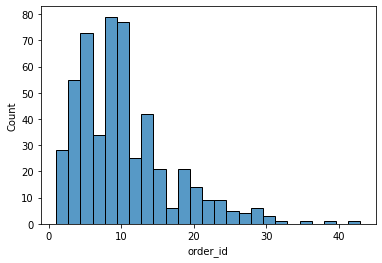

In [28]:
sns.histplot(df_orders_count_group0.order_id)

In [29]:
df_orders_count_group0.order_id.median()

9.0

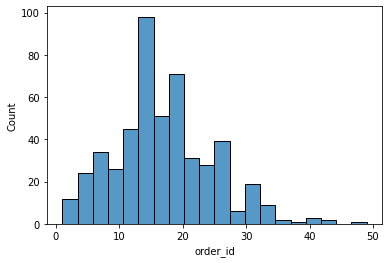

In [30]:
sns.histplot(df_orders_count_group1.order_id)

In [31]:
df_orders_count_group1.order_id.median()

16.0

Распределения здесь также отличаются от нормальных. Проведу тест на нормальность, если распределения не пройдут тест, то выбираю так же тесты Бутстрап и Манна-Уитни для сравнения медиан.

In [32]:
scipy.stats.normaltest(df_orders_count_group0.order_id)

NormaltestResult(statistic=122.12242493302108, pvalue=3.030067947928318e-27)

In [33]:
scipy.stats.normaltest(df_orders_count_group1.order_id)

NormaltestResult(statistic=30.26788079899512, pvalue=2.675550761917752e-07)

In [34]:
scipy.stats.bootstrap((df_orders_count_group0.order_id, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=8.0, high=9.0), standard_error=0.36777068110040756)

In [35]:
scipy.stats.bootstrap((df_orders_count_group1.order_id, ), np.median, method='basic')

BootstrapResult(confidence_interval=ConfidenceInterval(low=15.0, high=17.0), standard_error=0.4316942891220349)

In [36]:
scipy.stats.mannwhitneyu(df_orders_count_group0.order_id, df_orders_count_group1.order_id)

MannwhitneyuResult(statistic=64968.0, pvalue=5.724370781704199e-43)

Тест Бутстрап и Манна-Уитни показывают статзначимое увеличения количества заказов примерно на 77% в тестовой группе, что говорит о том, что несмотря на неизменный средний чек, пользователи всё равно стали больше покупать, а значит новая версия так или иначе увеличивает выручку продукта. Посчитаю выручку в контрольной и тестовых группах, чтобы понимать изменения в абсолютных величинах.

In [38]:
df_revenue_sum = df_revenue.groupby('group', as_index=False) \
                        .agg({'price': 'sum'})
df_revenue_sum

,group,price
0,0,643521.7
1,1,979835.6


**Ответ:** АБ-тест показал, что в новой версии приложения средний чек не изменился, но увеличилось количество заказов, что повлекло за собой большую выручку в тестовой группе - примерно на 330 тысяч рублей. В связи с этим можно раскатывать новую версию приложения на всех пользователей.